# Description

This notebook runs some pre-analyses using DBSCAN to explore the best set of parameters (`min_samples` and `eps`) to cluster `umap` data version.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

2

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=2
env: OPEN_BLAS_NUM_THREADS=2
env: NUMEXPR_NUM_THREADS=2
env: OMP_NUM_THREADS=2


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name
from clustering.ensembles.utils import generate_ensemble

# Global settings

In [5]:
np.random.seed(0)

In [6]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: umap

In [7]:
INPUT_SUBSET = "umap"

In [8]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [10]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

In [11]:
data = pd.read_pickle(input_filepath)

In [12]:
data.shape

(3752, 50)

In [13]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,9.587280,8.050184,9.340894,8.884522,4.562011,9.261327,9.078164,8.009141,9.288872,9.827831,...,9.753575,0.440851,-0.077164,-0.184829,9.345852,0.622542,-0.051136,4.266558,8.047482,-0.317385
100002_raw-Energy,9.910512,8.372274,9.605316,9.808598,4.641970,9.360196,8.848985,7.768594,9.231921,9.328465,...,9.647689,0.581584,0.547930,0.600128,8.976416,1.249645,0.234843,4.636343,7.173085,0.137119
100003_raw-Protein,9.923088,8.380640,9.609899,9.836457,4.647365,9.366775,8.835996,7.767549,9.230281,9.314386,...,9.642637,0.580362,0.565898,0.621073,8.967297,1.271435,0.243960,4.648671,7.149967,0.148192
100004_raw-Fat,9.898531,8.375697,9.600443,9.785713,4.639249,9.360721,8.886237,7.783376,9.237095,9.345434,...,9.648270,0.573073,0.521042,0.576926,8.979161,1.227988,0.231848,4.622777,7.205517,0.147385
100005_raw-Carbohydrate,9.895807,8.376662,9.605841,9.791338,4.636903,9.352356,8.867312,7.774787,9.233479,9.344456,...,9.652949,0.575161,0.529565,0.579919,8.988125,1.231771,0.226778,4.624360,7.194818,0.123104


## Tests different k values (k-NN)

In [14]:
k_values = np.arange(2, 125 + 1, 1)
k_values_to_explore = (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125)

In [15]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [16]:
eps_range_per_k = {
    k: (0.23, 0.80)
    if k < 5
    else (0.30, 0.80)
    if k < 10
    else (0.40, 2.50)
    if k < 20
    else (0.40, 7.00)
    if k < 50
    else (0.50, 10.00)
    for k in k_values
}

eps_range_per_k_to_explore = {k: eps_range_per_k[k] for k in k_values_to_explore}

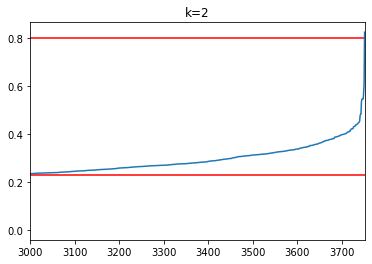

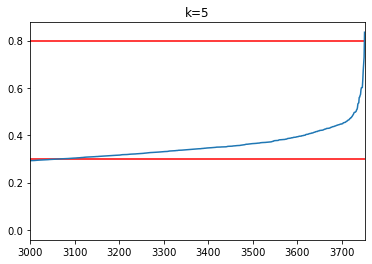

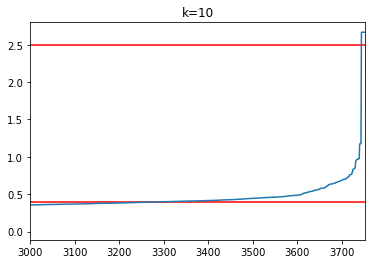

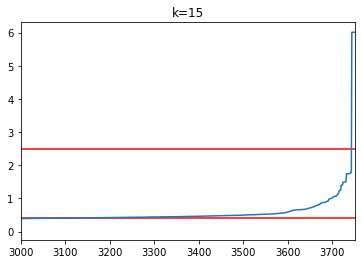

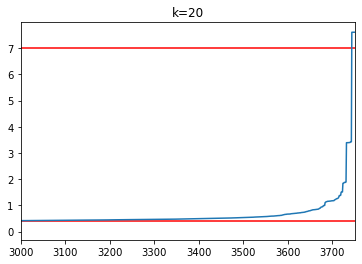

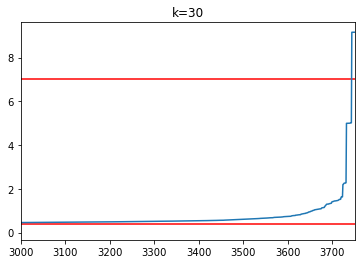

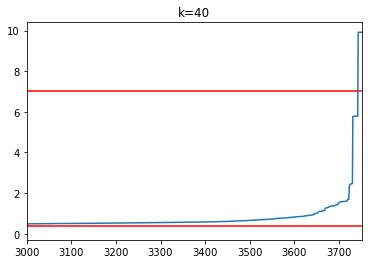

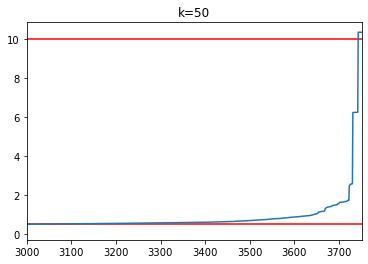

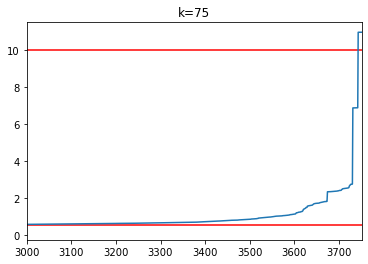

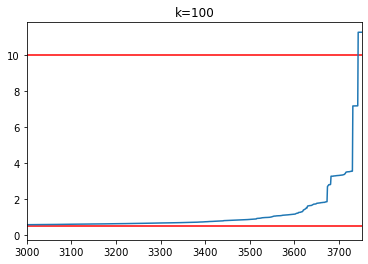

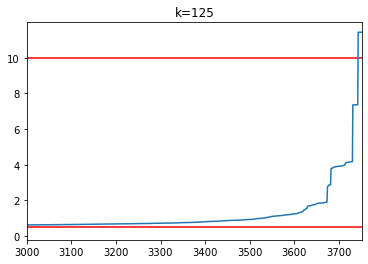

In [17]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

# Extended test

## Generate clusterers

In [18]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values_to_explore
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k_to_explore
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125),
 'EPS_RANGE_PER_K': {2: (0.23, 0.8),
  5: (0.3, 0.8),
  10: (0.4, 2.5),
  15: (0.4, 2.5),
  20: (0.4, 7.0),
  30: (0.4, 7.0),
  40: (0.4, 7.0),
  50: (0.5, 10.0),
  75: (0.5, 10.0),
  100: (0.5, 10.0),
  125: (0.5, 10.0)},
 'EPS_STEP': 33,
 'METRIC': 'euclidean'}

In [19]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [20]:
display(len(CLUSTERERS))

363

In [21]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=0.23, metric='precomputed', min_samples=2, n_jobs=2))

('DBSCAN #1',
 DBSCAN(eps=0.24781250000000002, metric='precomputed', min_samples=2, n_jobs=2))

In [22]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

## Generate ensemble

In [23]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [24]:
data_dist.shape

(3752, 3752)

In [25]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14077504.0
mean      3.086747407913208
std      1.5393855571746826
min                     0.0
25%        2.05721515417099
50%       3.083280563354492
75%      3.9437204003334045
max      15.400805473327637
dtype: object

In [26]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

  0%|          | 0/363 [00:00<?, ?it/s]

  1%|          | 2/363 [00:00<00:31, 11.28it/s]

  1%|          | 4/363 [00:00<00:32, 11.20it/s]

  2%|▏         | 6/363 [00:00<00:32, 11.12it/s]

  2%|▏         | 8/363 [00:00<00:32, 11.01it/s]

  3%|▎         | 10/363 [00:00<00:32, 10.93it/s]

  3%|▎         | 12/363 [00:01<00:32, 10.82it/s]

  4%|▍         | 14/363 [00:01<00:32, 10.76it/s]

  4%|▍         | 16/363 [00:01<00:32, 10.70it/s]

  5%|▍         | 18/363 [00:01<00:32, 10.66it/s]

  6%|▌         | 20/363 [00:01<00:32, 10.59it/s]

  6%|▌         | 22/363 [00:02<00:32, 10.50it/s]

  7%|▋         | 24/363 [00:02<00:32, 10.43it/s]

  7%|▋         | 26/363 [00:02<00:32, 10.40it/s]

  8%|▊         | 28/363 [00:02<00:32, 10.37it/s]

  8%|▊         | 30/363 [00:02<00:32, 10.32it/s]

  9%|▉         | 32/363 [00:03<00:32, 10.29it/s]

  9%|▉         | 34/363 [00:03<00:34,  9.52it/s]

 10%|▉         | 36/363 [00:03<00:32,  9.94it/s]

 10%|█         | 38/363 [00:03<00:31, 10.23it/s]

 11%|█         | 40/363 [00:03<00:31, 10.39it/s]

 12%|█▏        | 42/363 [00:04<00:30, 10.46it/s]

 12%|█▏        | 44/363 [00:04<00:30, 10.46it/s]

 13%|█▎        | 46/363 [00:04<00:30, 10.44it/s]

 13%|█▎        | 48/363 [00:04<00:30, 10.41it/s]

 14%|█▍        | 50/363 [00:04<00:30, 10.39it/s]

 14%|█▍        | 52/363 [00:04<00:29, 10.38it/s]

 15%|█▍        | 54/363 [00:05<00:30, 10.30it/s]

 15%|█▌        | 56/363 [00:05<00:29, 10.27it/s]

 16%|█▌        | 58/363 [00:05<00:29, 10.24it/s]

 17%|█▋        | 60/363 [00:05<00:29, 10.21it/s]

 17%|█▋        | 62/363 [00:05<00:29, 10.15it/s]

 18%|█▊        | 64/363 [00:06<00:29, 10.11it/s]

 18%|█▊        | 66/363 [00:06<00:29, 10.07it/s]

 19%|█▊        | 68/363 [00:06<00:28, 10.31it/s]

 19%|█▉        | 70/363 [00:06<00:28, 10.34it/s]

 20%|█▉        | 72/363 [00:06<00:28, 10.29it/s]

 20%|██        | 74/363 [00:07<00:28, 10.14it/s]

 21%|██        | 76/363 [00:07<00:28, 10.02it/s]

 21%|██▏       | 78/363 [00:07<00:28,  9.83it/s]

 22%|██▏       | 79/363 [00:07<00:29,  9.65it/s]

 22%|██▏       | 80/363 [00:07<00:29,  9.49it/s]

 22%|██▏       | 81/363 [00:07<00:30,  9.32it/s]

 23%|██▎       | 82/363 [00:08<00:34,  8.21it/s]

 23%|██▎       | 83/363 [00:08<00:33,  8.24it/s]

 23%|██▎       | 84/363 [00:08<00:33,  8.38it/s]

 23%|██▎       | 85/363 [00:08<00:33,  8.35it/s]

 24%|██▎       | 86/363 [00:08<00:33,  8.33it/s]

 24%|██▍       | 87/363 [00:08<00:33,  8.36it/s]

 24%|██▍       | 88/363 [00:08<00:32,  8.38it/s]

 25%|██▍       | 89/363 [00:08<00:32,  8.39it/s]

 25%|██▍       | 90/363 [00:08<00:32,  8.37it/s]

 25%|██▌       | 91/363 [00:09<00:32,  8.31it/s]

 25%|██▌       | 92/363 [00:09<00:32,  8.27it/s]

 26%|██▌       | 93/363 [00:09<00:32,  8.23it/s]

 26%|██▌       | 94/363 [00:09<00:32,  8.20it/s]

 26%|██▌       | 95/363 [00:09<00:32,  8.15it/s]

 26%|██▋       | 96/363 [00:09<00:33,  7.96it/s]

 27%|██▋       | 97/363 [00:09<00:34,  7.82it/s]

 27%|██▋       | 98/363 [00:10<00:34,  7.71it/s]

 27%|██▋       | 99/363 [00:10<00:34,  7.58it/s]

 28%|██▊       | 101/363 [00:10<00:31,  8.35it/s]

 28%|██▊       | 103/363 [00:10<00:29,  8.90it/s]

 29%|██▉       | 105/363 [00:10<00:27,  9.26it/s]

 29%|██▉       | 106/363 [00:10<00:27,  9.47it/s]

 29%|██▉       | 107/363 [00:10<00:26,  9.57it/s]

 30%|██▉       | 108/363 [00:11<00:26,  9.60it/s]

 30%|███       | 109/363 [00:11<00:26,  9.61it/s]

 30%|███       | 110/363 [00:11<00:26,  9.53it/s]

 31%|███       | 111/363 [00:11<00:26,  9.51it/s]

 31%|███       | 112/363 [00:11<00:26,  9.44it/s]

 31%|███       | 113/363 [00:11<00:26,  9.37it/s]

 31%|███▏      | 114/363 [00:11<00:26,  9.27it/s]

 32%|███▏      | 115/363 [00:11<00:27,  9.18it/s]

 32%|███▏      | 116/363 [00:11<00:27,  9.09it/s]

 32%|███▏      | 117/363 [00:12<00:27,  8.96it/s]

 33%|███▎      | 118/363 [00:12<00:28,  8.74it/s]

 33%|███▎      | 119/363 [00:12<00:28,  8.62it/s]

 33%|███▎      | 120/363 [00:12<00:28,  8.58it/s]

 33%|███▎      | 121/363 [00:12<00:28,  8.56it/s]

 34%|███▎      | 122/363 [00:12<00:28,  8.52it/s]

 34%|███▍      | 123/363 [00:12<00:28,  8.48it/s]

 34%|███▍      | 124/363 [00:12<00:28,  8.45it/s]

 34%|███▍      | 125/363 [00:12<00:28,  8.39it/s]

 35%|███▍      | 126/363 [00:13<00:28,  8.37it/s]

 35%|███▍      | 127/363 [00:13<00:28,  8.27it/s]

 35%|███▌      | 128/363 [00:13<00:28,  8.26it/s]

 36%|███▌      | 129/363 [00:13<00:32,  7.23it/s]

 36%|███▌      | 130/363 [00:13<00:32,  7.27it/s]

 36%|███▌      | 131/363 [00:13<00:31,  7.32it/s]

 36%|███▋      | 132/363 [00:13<00:31,  7.36it/s]

 37%|███▋      | 134/363 [00:14<00:28,  8.16it/s]

 37%|███▋      | 135/363 [00:14<00:26,  8.58it/s]

 37%|███▋      | 136/363 [00:14<00:25,  8.88it/s]

 38%|███▊      | 137/363 [00:14<00:25,  8.94it/s]

 38%|███▊      | 138/363 [00:14<00:25,  8.91it/s]

 38%|███▊      | 139/363 [00:14<00:25,  8.72it/s]

 39%|███▊      | 140/363 [00:14<00:25,  8.61it/s]

 39%|███▉      | 141/363 [00:14<00:26,  8.50it/s]

 39%|███▉      | 142/363 [00:15<00:26,  8.38it/s]

 39%|███▉      | 143/363 [00:15<00:27,  8.05it/s]

 40%|███▉      | 144/363 [00:15<00:28,  7.78it/s]

 40%|███▉      | 145/363 [00:15<00:28,  7.56it/s]

 40%|████      | 146/363 [00:15<00:29,  7.38it/s]

 40%|████      | 147/363 [00:15<00:30,  7.17it/s]

 41%|████      | 148/363 [00:15<00:32,  6.60it/s]

 41%|████      | 149/363 [00:16<00:34,  6.24it/s]

 41%|████▏     | 150/363 [00:16<00:35,  5.96it/s]

 42%|████▏     | 151/363 [00:16<00:36,  5.76it/s]

 42%|████▏     | 152/363 [00:16<00:37,  5.64it/s]

 42%|████▏     | 153/363 [00:16<00:37,  5.55it/s]

 42%|████▏     | 154/363 [00:17<00:37,  5.50it/s]

 43%|████▎     | 155/363 [00:17<00:38,  5.47it/s]

 43%|████▎     | 156/363 [00:17<00:37,  5.45it/s]

 43%|████▎     | 157/363 [00:17<00:37,  5.46it/s]

 44%|████▎     | 158/363 [00:17<00:37,  5.46it/s]

 44%|████▍     | 159/363 [00:17<00:37,  5.48it/s]

 44%|████▍     | 160/363 [00:18<00:36,  5.50it/s]

 44%|████▍     | 161/363 [00:18<00:36,  5.50it/s]

 45%|████▍     | 162/363 [00:18<00:35,  5.59it/s]

 45%|████▍     | 163/363 [00:18<00:35,  5.57it/s]

 45%|████▌     | 164/363 [00:18<00:35,  5.56it/s]

 45%|████▌     | 165/363 [00:18<00:35,  5.56it/s]

 46%|████▌     | 167/363 [00:19<00:30,  6.53it/s]

 46%|████▋     | 168/363 [00:19<00:26,  7.29it/s]

 47%|████▋     | 169/363 [00:19<00:24,  7.85it/s]

 47%|████▋     | 170/363 [00:19<00:23,  8.20it/s]

 47%|████▋     | 171/363 [00:19<00:22,  8.39it/s]

 47%|████▋     | 172/363 [00:19<00:22,  8.37it/s]

 48%|████▊     | 173/363 [00:19<00:22,  8.37it/s]

 48%|████▊     | 174/363 [00:19<00:22,  8.34it/s]

 48%|████▊     | 175/363 [00:20<00:22,  8.29it/s]

 48%|████▊     | 176/363 [00:20<00:23,  7.98it/s]

 49%|████▉     | 177/363 [00:20<00:26,  7.01it/s]

 49%|████▉     | 178/363 [00:20<00:26,  7.02it/s]

 49%|████▉     | 179/363 [00:20<00:26,  7.02it/s]

 50%|████▉     | 180/363 [00:20<00:26,  6.98it/s]

 50%|████▉     | 181/363 [00:20<00:27,  6.68it/s]

 50%|█████     | 182/363 [00:21<00:28,  6.45it/s]

 50%|█████     | 183/363 [00:21<00:28,  6.29it/s]

 51%|█████     | 184/363 [00:21<00:29,  6.16it/s]

 51%|█████     | 185/363 [00:21<00:29,  6.07it/s]

 51%|█████     | 186/363 [00:21<00:29,  5.99it/s]

 52%|█████▏    | 187/363 [00:22<00:29,  5.93it/s]

 52%|█████▏    | 188/363 [00:22<00:29,  5.88it/s]

 52%|█████▏    | 189/363 [00:22<00:29,  5.87it/s]

 52%|█████▏    | 190/363 [00:22<00:29,  5.86it/s]

 53%|█████▎    | 191/363 [00:22<00:29,  5.87it/s]

 53%|█████▎    | 192/363 [00:22<00:29,  5.88it/s]

 53%|█████▎    | 193/363 [00:23<00:28,  5.87it/s]

 53%|█████▎    | 194/363 [00:23<00:28,  5.86it/s]

 54%|█████▎    | 195/363 [00:23<00:28,  5.87it/s]

 54%|█████▍    | 196/363 [00:23<00:28,  5.87it/s]

 54%|█████▍    | 197/363 [00:23<00:28,  5.86it/s]

 55%|█████▍    | 198/363 [00:23<00:28,  5.86it/s]

 55%|█████▌    | 200/363 [00:24<00:23,  6.88it/s]

 55%|█████▌    | 201/363 [00:24<00:21,  7.57it/s]

 56%|█████▌    | 202/363 [00:24<00:19,  8.09it/s]

 56%|█████▌    | 203/363 [00:24<00:19,  8.39it/s]

 56%|█████▌    | 204/363 [00:24<00:18,  8.51it/s]

 56%|█████▋    | 205/363 [00:24<00:18,  8.52it/s]

 57%|█████▋    | 206/363 [00:24<00:18,  8.48it/s]

 57%|█████▋    | 207/363 [00:24<00:18,  8.41it/s]

 57%|█████▋    | 208/363 [00:24<00:18,  8.33it/s]

 58%|█████▊    | 209/363 [00:25<00:19,  8.06it/s]

 58%|█████▊    | 210/363 [00:25<00:19,  7.81it/s]

 58%|█████▊    | 211/363 [00:25<00:19,  7.61it/s]

 58%|█████▊    | 212/363 [00:25<00:20,  7.43it/s]

 59%|█████▊    | 213/363 [00:25<00:20,  7.26it/s]

 59%|█████▉    | 214/363 [00:25<00:21,  6.87it/s]

 59%|█████▉    | 215/363 [00:26<00:22,  6.61it/s]

 60%|█████▉    | 216/363 [00:26<00:23,  6.36it/s]

 60%|█████▉    | 217/363 [00:26<00:23,  6.17it/s]

 60%|██████    | 218/363 [00:26<00:23,  6.07it/s]

 60%|██████    | 219/363 [00:26<00:24,  5.99it/s]

 61%|██████    | 220/363 [00:26<00:24,  5.94it/s]

 61%|██████    | 221/363 [00:27<00:24,  5.92it/s]

 61%|██████    | 222/363 [00:27<00:24,  5.87it/s]

 61%|██████▏   | 223/363 [00:27<00:23,  5.85it/s]

 62%|██████▏   | 224/363 [00:27<00:25,  5.36it/s]

 62%|██████▏   | 225/363 [00:27<00:25,  5.49it/s]

 62%|██████▏   | 226/363 [00:27<00:24,  5.60it/s]

 63%|██████▎   | 227/363 [00:28<00:23,  5.67it/s]

 63%|██████▎   | 228/363 [00:28<00:23,  5.70it/s]

 63%|██████▎   | 229/363 [00:28<00:23,  5.74it/s]

 63%|██████▎   | 230/363 [00:28<00:23,  5.78it/s]

 64%|██████▎   | 231/363 [00:28<00:22,  5.79it/s]

 64%|██████▍   | 233/363 [00:28<00:19,  6.75it/s]

 64%|██████▍   | 234/363 [00:29<00:17,  7.40it/s]

 65%|██████▍   | 235/363 [00:29<00:16,  7.78it/s]

 65%|██████▌   | 236/363 [00:29<00:15,  7.98it/s]

 65%|██████▌   | 237/363 [00:29<00:15,  8.12it/s]

 66%|██████▌   | 238/363 [00:29<00:15,  7.99it/s]

 66%|██████▌   | 239/363 [00:29<00:15,  7.82it/s]

 66%|██████▌   | 240/363 [00:29<00:16,  7.67it/s]

 66%|██████▋   | 241/363 [00:29<00:16,  7.48it/s]

 67%|██████▋   | 242/363 [00:30<00:17,  7.03it/s]

 67%|██████▋   | 243/363 [00:30<00:17,  6.70it/s]

 67%|██████▋   | 244/363 [00:30<00:18,  6.44it/s]

 67%|██████▋   | 245/363 [00:30<00:18,  6.26it/s]

 68%|██████▊   | 246/363 [00:30<00:19,  6.13it/s]

 68%|██████▊   | 247/363 [00:30<00:19,  6.04it/s]

 68%|██████▊   | 248/363 [00:31<00:19,  5.99it/s]

 69%|██████▊   | 249/363 [00:31<00:19,  5.92it/s]

 69%|██████▉   | 250/363 [00:31<00:19,  5.91it/s]

 69%|██████▉   | 251/363 [00:31<00:18,  5.90it/s]

 69%|██████▉   | 252/363 [00:31<00:18,  5.89it/s]

 70%|██████▉   | 253/363 [00:32<00:18,  5.88it/s]

 70%|██████▉   | 254/363 [00:32<00:18,  5.87it/s]

 70%|███████   | 255/363 [00:32<00:18,  5.84it/s]

 71%|███████   | 256/363 [00:32<00:18,  5.84it/s]

 71%|███████   | 257/363 [00:32<00:18,  5.84it/s]

 71%|███████   | 258/363 [00:32<00:17,  5.85it/s]

 71%|███████▏  | 259/363 [00:33<00:17,  5.83it/s]

 72%|███████▏  | 260/363 [00:33<00:17,  5.82it/s]

 72%|███████▏  | 261/363 [00:33<00:17,  5.82it/s]

 72%|███████▏  | 262/363 [00:33<00:17,  5.84it/s]

 72%|███████▏  | 263/363 [00:33<00:17,  5.83it/s]

 73%|███████▎  | 264/363 [00:33<00:16,  5.84it/s]

 73%|███████▎  | 266/363 [00:34<00:14,  6.86it/s]

 74%|███████▎  | 267/363 [00:34<00:12,  7.50it/s]

 74%|███████▍  | 268/363 [00:34<00:12,  7.87it/s]

 74%|███████▍  | 269/363 [00:34<00:11,  8.07it/s]

 74%|███████▍  | 270/363 [00:34<00:11,  8.17it/s]

 75%|███████▍  | 271/363 [00:34<00:12,  7.25it/s]

 75%|███████▍  | 272/363 [00:34<00:12,  7.24it/s]

 75%|███████▌  | 273/363 [00:34<00:12,  7.25it/s]

 75%|███████▌  | 274/363 [00:35<00:12,  7.18it/s]

 76%|███████▌  | 275/363 [00:35<00:12,  6.82it/s]

 76%|███████▌  | 276/363 [00:35<00:13,  6.56it/s]

 76%|███████▋  | 277/363 [00:35<00:13,  6.35it/s]

 77%|███████▋  | 278/363 [00:35<00:13,  6.21it/s]

 77%|███████▋  | 279/363 [00:35<00:13,  6.10it/s]

 77%|███████▋  | 280/363 [00:36<00:13,  6.02it/s]

 77%|███████▋  | 281/363 [00:36<00:13,  5.95it/s]

 78%|███████▊  | 282/363 [00:36<00:13,  5.93it/s]

 78%|███████▊  | 283/363 [00:36<00:13,  5.92it/s]

 78%|███████▊  | 284/363 [00:36<00:13,  5.90it/s]

 79%|███████▊  | 285/363 [00:36<00:13,  5.90it/s]

 79%|███████▉  | 286/363 [00:37<00:13,  5.88it/s]

 79%|███████▉  | 287/363 [00:37<00:12,  5.85it/s]

 79%|███████▉  | 288/363 [00:37<00:12,  5.86it/s]

 80%|███████▉  | 289/363 [00:37<00:12,  5.87it/s]

 80%|███████▉  | 290/363 [00:37<00:12,  5.86it/s]

 80%|████████  | 291/363 [00:38<00:12,  5.86it/s]

 80%|████████  | 292/363 [00:38<00:12,  5.85it/s]

 81%|████████  | 293/363 [00:38<00:11,  5.84it/s]

 81%|████████  | 294/363 [00:38<00:11,  5.83it/s]

 81%|████████▏ | 295/363 [00:38<00:11,  5.84it/s]

 82%|████████▏ | 296/363 [00:38<00:11,  5.85it/s]

 82%|████████▏ | 297/363 [00:39<00:11,  5.84it/s]

 82%|████████▏ | 299/363 [00:39<00:09,  6.89it/s]

 83%|████████▎ | 300/363 [00:39<00:08,  7.49it/s]

 83%|████████▎ | 301/363 [00:39<00:07,  7.88it/s]

 83%|████████▎ | 302/363 [00:39<00:07,  8.07it/s]

 83%|████████▎ | 303/363 [00:39<00:07,  8.17it/s]

 84%|████████▎ | 304/363 [00:39<00:07,  8.03it/s]

 84%|████████▍ | 305/363 [00:39<00:07,  7.88it/s]

 84%|████████▍ | 306/363 [00:40<00:07,  7.70it/s]

 85%|████████▍ | 307/363 [00:40<00:07,  7.50it/s]

 85%|████████▍ | 308/363 [00:40<00:07,  7.03it/s]

 85%|████████▌ | 309/363 [00:40<00:08,  6.72it/s]

 85%|████████▌ | 310/363 [00:40<00:08,  6.47it/s]

 86%|████████▌ | 311/363 [00:40<00:08,  6.29it/s]

 86%|████████▌ | 312/363 [00:41<00:08,  6.17it/s]

 86%|████████▌ | 313/363 [00:41<00:08,  6.08it/s]

 87%|████████▋ | 314/363 [00:41<00:08,  6.01it/s]

 87%|████████▋ | 315/363 [00:41<00:08,  5.98it/s]

 87%|████████▋ | 316/363 [00:41<00:07,  5.95it/s]

 87%|████████▋ | 317/363 [00:41<00:07,  5.93it/s]

 88%|████████▊ | 318/363 [00:42<00:07,  5.92it/s]

 88%|████████▊ | 319/363 [00:42<00:07,  5.90it/s]

 88%|████████▊ | 320/363 [00:42<00:07,  5.87it/s]

 88%|████████▊ | 321/363 [00:42<00:07,  5.41it/s]

 89%|████████▊ | 322/363 [00:42<00:07,  5.50it/s]

 89%|████████▉ | 323/363 [00:42<00:07,  5.60it/s]

 89%|████████▉ | 324/363 [00:43<00:06,  5.66it/s]

 90%|████████▉ | 325/363 [00:43<00:06,  5.68it/s]

 90%|████████▉ | 326/363 [00:43<00:06,  5.73it/s]

 90%|█████████ | 327/363 [00:43<00:06,  5.77it/s]

 90%|█████████ | 328/363 [00:43<00:06,  5.78it/s]

 91%|█████████ | 329/363 [00:43<00:05,  5.80it/s]

 91%|█████████ | 330/363 [00:44<00:05,  5.81it/s]

 91%|█████████▏| 332/363 [00:44<00:04,  6.89it/s]

 92%|█████████▏| 333/363 [00:44<00:03,  7.54it/s]

 92%|█████████▏| 334/363 [00:44<00:03,  7.93it/s]

 92%|█████████▏| 335/363 [00:44<00:03,  8.13it/s]

 93%|█████████▎| 336/363 [00:44<00:03,  8.22it/s]

 93%|█████████▎| 337/363 [00:44<00:03,  8.06it/s]

 93%|█████████▎| 338/363 [00:45<00:03,  7.87it/s]

 93%|█████████▎| 339/363 [00:45<00:03,  7.68it/s]

 94%|█████████▎| 340/363 [00:45<00:03,  7.46it/s]

 94%|█████████▍| 341/363 [00:45<00:03,  7.03it/s]

 94%|█████████▍| 342/363 [00:45<00:03,  6.70it/s]

 94%|█████████▍| 343/363 [00:45<00:03,  6.45it/s]

 95%|█████████▍| 344/363 [00:45<00:03,  6.28it/s]

 95%|█████████▌| 345/363 [00:46<00:02,  6.15it/s]

 95%|█████████▌| 346/363 [00:46<00:02,  6.05it/s]

 96%|█████████▌| 347/363 [00:46<00:02,  6.00it/s]

 96%|█████████▌| 348/363 [00:46<00:02,  5.97it/s]

 96%|█████████▌| 349/363 [00:46<00:02,  5.93it/s]

 96%|█████████▋| 350/363 [00:47<00:02,  5.92it/s]

 97%|█████████▋| 351/363 [00:47<00:02,  5.91it/s]

 97%|█████████▋| 352/363 [00:47<00:01,  5.88it/s]

 97%|█████████▋| 353/363 [00:47<00:01,  5.88it/s]

 98%|█████████▊| 354/363 [00:47<00:01,  5.86it/s]

 98%|█████████▊| 355/363 [00:47<00:01,  5.86it/s]

 98%|█████████▊| 356/363 [00:48<00:01,  5.86it/s]

 98%|█████████▊| 357/363 [00:48<00:01,  5.85it/s]

 99%|█████████▊| 358/363 [00:48<00:00,  5.82it/s]

 99%|█████████▉| 359/363 [00:48<00:00,  5.84it/s]

 99%|█████████▉| 360/363 [00:48<00:00,  5.84it/s]

 99%|█████████▉| 361/363 [00:48<00:00,  5.84it/s]

100%|█████████▉| 362/363 [00:49<00:00,  5.85it/s]

100%|██████████| 363/363 [00:49<00:00,  5.84it/s]

100%|██████████| 363/363 [00:49<00:00,  7.37it/s]

In [27]:
ensemble.shape

(209, 3)

In [28]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 0.23, 'leaf_size'...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",317
DBSCAN #1,"{'algorithm': 'auto', 'eps': 0.247812500000000...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",301
DBSCAN #2,"{'algorithm': 'auto', 'eps': 0.265625, 'leaf_s...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",272
DBSCAN #3,"{'algorithm': 'auto', 'eps': 0.2834375, 'leaf_...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",257
DBSCAN #4,"{'algorithm': 'auto', 'eps': 0.30125, 'leaf_si...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",226


In [29]:
_tmp = ensemble["n_clusters"].value_counts()
display(_tmp)
assert _tmp.index[0] == 2
assert _tmp.loc[2] == 95

2      95
3      18
4      15
17      8
16      7
6       7
22      6
5       4
21      4
7       3
31      3
37      2
23      2
32      2
33      2
36      2
26      2
40      2
24      2
20      1
18      1
272     1
10      1
45      1
226     1
30      1
25      1
27      1
29      1
189     1
301     1
47      1
54      1
60      1
317     1
64      1
76      1
93      1
110     1
125     1
154     1
257     1
Name: n_clusters, dtype: int64

In [30]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    209.000000
mean      19.114833
std       46.793390
min        2.000000
25%        2.000000
50%        3.000000
75%       17.000000
max      317.000000
Name: n_clusters, dtype: float64

In [31]:
# number of noisy points
_tmp = ensemble.copy()
_tmp = _tmp.assign(n_noisy=ensemble["partition"].apply(lambda x: np.isnan(x).sum()))

In [32]:
_tmp_stats = _tmp["n_noisy"].describe()
display(_tmp_stats)
assert _tmp_stats["min"] >= 1
assert _tmp_stats["max"] < 2105
assert 110 < _tmp_stats["mean"] < 120

count     209.000000
mean      114.100478
std       230.839239
min         1.000000
25%        20.000000
50%        34.000000
75%        93.000000
max      2104.000000
Name: n_noisy, dtype: float64

## Testing

In [33]:
assert ensemble_stats["min"] > 1

In [34]:
assert not ensemble["n_clusters"].isna().any()

In [35]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

## Add clustering quality measures

In [36]:
def _remove_nans(data, part):
    not_nan_idx = ~np.isnan(part)
    return data.iloc[not_nan_idx], part[not_nan_idx]


def _apply_func(func, data, part):
    no_nan_data, no_nan_part = _remove_nans(data, part)
    return func(no_nan_data, no_nan_part)

In [37]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: _apply_func(silhouette_score, data, x)
    ),
    ch_score=ensemble["partition"].apply(
        lambda x: _apply_func(calinski_harabasz_score, data, x)
    ),
    db_score=ensemble["partition"].apply(
        lambda x: _apply_func(davies_bouldin_score, data, x)
    ),
)

In [38]:
ensemble.shape

(209, 6)

In [39]:
ensemble.head()

,clusterer_params,partition,n_clusters,si_score,ch_score,db_score
clusterer_id,,,,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 0.23, 'leaf_size'...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",317,-0.264103,15.603481,1.063393
DBSCAN #1,"{'algorithm': 'auto', 'eps': 0.247812500000000...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",301,-0.310631,7.521820,1.219808
DBSCAN #2,"{'algorithm': 'auto', 'eps': 0.265625, 'leaf_s...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",272,-0.370136,7.085862,1.249468
DBSCAN #3,"{'algorithm': 'auto', 'eps': 0.2834375, 'leaf_...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",257,-0.397438,7.349832,1.232750
DBSCAN #4,"{'algorithm': 'auto', 'eps': 0.30125, 'leaf_si...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",226,-0.427738,7.855357,1.253311


# Cluster quality

In [40]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,si_score,ch_score,db_score
n_clusters,,,
2,0.591376,445.398871,0.360929
3,0.422144,283.448233,0.515578
4,-0.020071,273.928295,0.779726
5,-0.155168,152.557401,0.938486
6,-0.274450,122.265991,1.297242
7,-0.024478,649.842085,1.083391
10,-0.357169,76.074582,2.827169
16,-0.306313,69.567497,0.822597
17,-0.327810,65.626853,0.865484


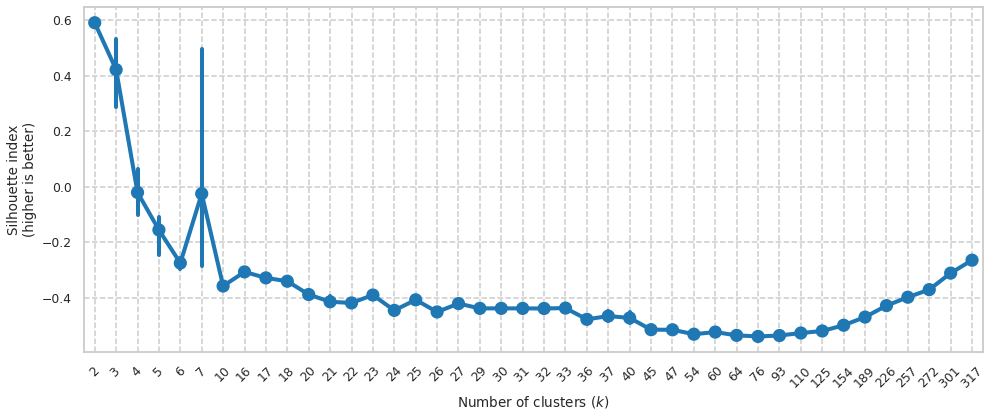

In [41]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

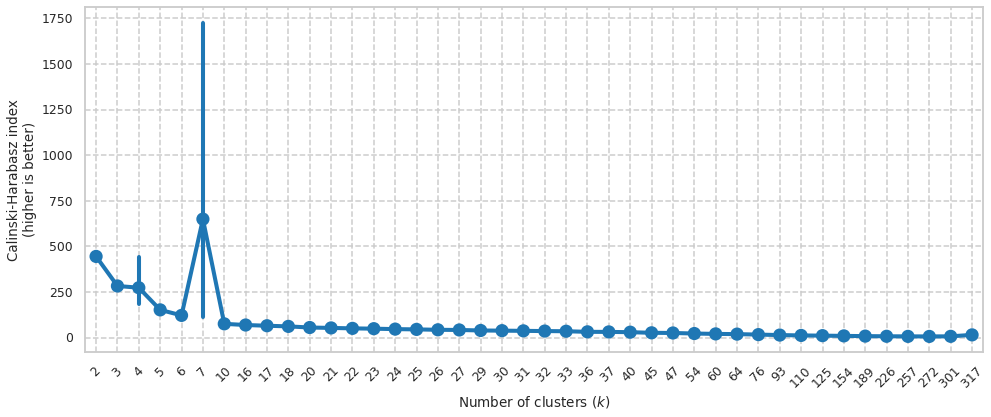

In [42]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

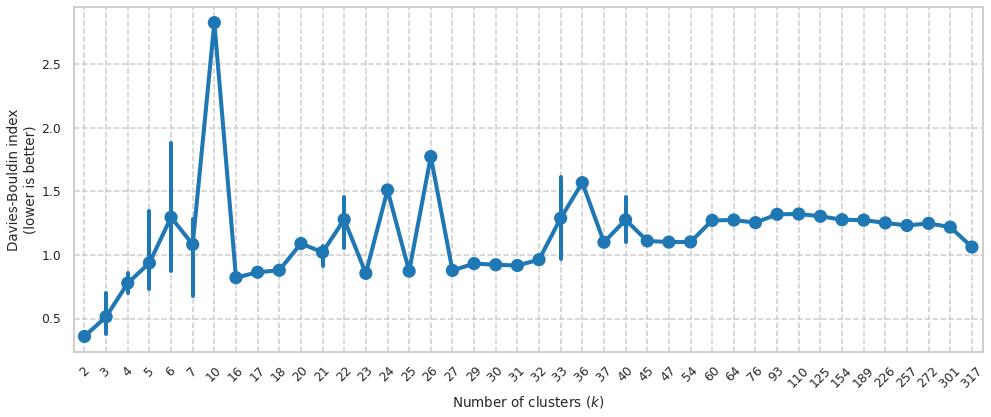

In [43]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="db_score")
    ax.set_ylabel("Davies-Bouldin index\n(lower is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Conclusions

The values explored above for `k_values` and `eps_range_per_k` are the one that will be used for DBSCAN in this data version.